In [8]:
%run /Users/denis/Documents/Projects/scripts/init.ipy
os.chdir('/Users/denis/Documents/Projects/idg/tcga-data')
%R require(survival);

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/Users/denis/my-venv/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:

Loading required package: survival




array([1], dtype=int32)

### Infiles

### Computation

In [80]:
def plotSurvivalAssociation(geneSymbol, tumorType, sampleType='01', nGroups=3, colors=['#fed976','#fc4e2a','#bd0026']):
    
    # Read dataframes
    expressionDataframe = pd.read_table('%(tumorType)s/%(tumorType)s-fpkm-uq.txt' % locals(), index_col='gene_symbol')
    survivalDataframe = pd.read_table('%(tumorType)s/%(tumorType)s-survival.txt' % locals(), index_col='patient_barcode')
    survivalDataframe['last_checked'] = [days_to_death if not np.isnan(days_to_death) else days_to_last_followup for days_to_death, days_to_last_followup in survivalDataframe[['days_to_death', 'days_to_last_followup']].as_matrix()]
    
    # Get column types
    cols = [x for x in expressionDataframe.columns if x.split('-')[-1]==sampleType]
    expressionDataframeSubset = expressionDataframe[cols]

    # Fix patient columns
    expressionDataframeSubset.columns = ['-'.join(x.split('-')[:3]) for x in expressionDataframeSubset.columns]

    # Aggregate
    expressionDataframeSubset = expressionDataframeSubset.T.reset_index().groupby('index').mean().T

    # Get common patients
    commonPatients = list(set(expressionDataframeSubset.columns).intersection(set(survivalDataframe.index)))
    expressionDataframeSubset = expressionDataframeSubset[commonPatients]

    # Split samples
    split_cols = np.array_split(expressionDataframeSubset.loc[geneSymbol].to_frame().sort_values(geneSymbol).index.tolist(), nGroups)
    groupDataframe = pd.DataFrame([[x, i] for i in range(len(split_cols)) for x in split_cols[i]], columns=['patient_barcode','group']).set_index('patient_barcode')

    # Check order
    survivalDataframeSubset = survivalDataframe.loc[groupDataframe.index, ['vital_status', 'last_checked']]
    survivalDataframeSubset['event'] = [x=='Dead' for x in survivalDataframeSubset['vital_status']]
    
    # Run R
    %R -i survivalDataframeSubset,groupDataframe,colors,geneSymbol,tumorType
    %R survivalObj <- Surv(time=survivalDataframeSubset$last_checked, event=survivalDataframeSubset$event);
    %R sfit <- survfit(survivalObj ~ groupDataframe$group);
    %R sdiff <- survdiff(survivalObj ~ groupDataframe$group);
    %R p <- 1 - pchisq(sdiff$chisq, df=length(sdiff$n) - 1);
    %R par(mar=c(5,4,5,2)); plot(sfit, lwd=3, xlab="days", ylab="Percent Survival", col=colors, main=paste('Association between', as.character(geneSymbol),'and survival in',as.character(tumorType)));grid(col="grey"); mtext(paste("p=",format.pval(p,digits=3)," (Samples: ",nrow(survivalObj)," - Deaths: ",sum(survivalObj[,2], na.rm=TRUE),")",sep=""), padj=-0.75); legend("bottomleft",col=colors,legend=c('Low', 'Medium', 'High'),lty=1,lwd=3,bg="white")

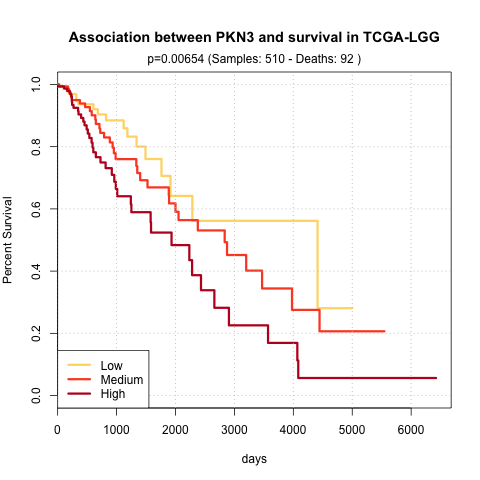

In [143]:
plotSurvivalAssociation('PKN3', 'TCGA-LGG', nGroups=3)

In [147]:
def plotDifferentialExpression(geneSymbol, tumorType, sampleTypes=False, colors=['#fbb4ae','#b3cde3','#decbe4','#fed9a6']):
    
    # Read dataframes
    expressionDataframe = pd.read_table('%(tumorType)s/%(tumorType)s-fpkm-uq.txt' % locals(), index_col='gene_symbol')

    # Get conversion
    sampleDict = {'01': 'Primary Tumor', '11': 'Normal Tissue', '06': 'Metastatis', '02': 'Dunno', '05': 'Boh'}

    # Get subset
    expressionDataframeSubset = expressionDataframe.loc[geneSymbol].to_frame().rename(columns={geneSymbol:'expression'})
    expressionDataframeSubset['expression'] = np.log10(expressionDataframeSubset['expression'])+1
    expressionDataframeSubset['sample_type'] = [x.split('-')[-1] for x in expressionDataframeSubset.index]
    
    # Filter
    if sampleTypes:
        expressionDataframeSubset = expressionDataframeSubset[expressionDataframeSubset['sample_type'].isin(sampleTypes)]
        
    # Label
#     expressionDataframeSubset['sample_label'] = [sampleDict[x] for x in expressionDataframeSubset['sample_type']]
    
    %R -h 500 -w 300 -i expressionDataframeSubset,geneSymbol,tumorType boxplot(expression ~ sample_label, data=expressionDataframeSubset, log='y', xlab='', ylab=expression('Expression (log'[10]*' FPKM)'), col=colors, main=paste(geneSymbol, 'expression in', tumorType));

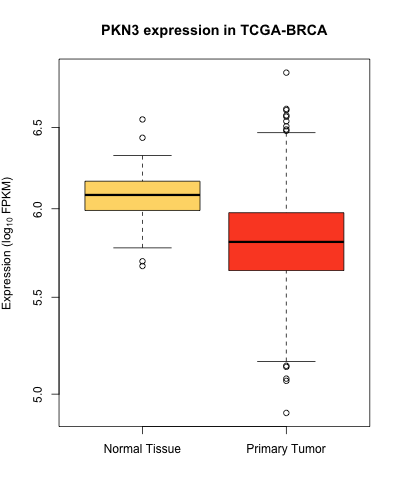

In [146]:
plotDifferentialExpression('PKN3', 'TCGA-BRCA', ['01', '11'])

### PKMYT1

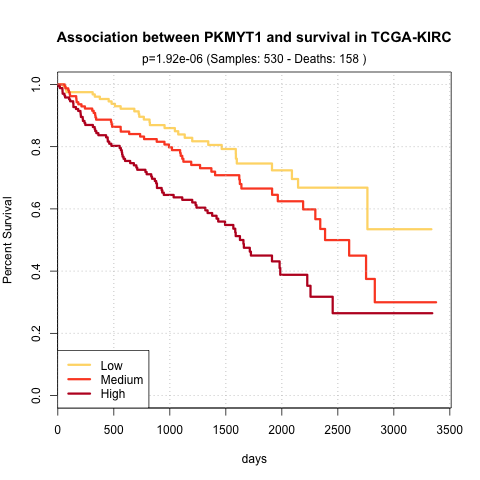

In [101]:
plotSurvivalAssociation('PKMYT1', 'TCGA-KIRC', nGroups=3)


Error in boxplot.default(split(mf[[response]], mf[-response]), ...) : 
  invalid first argument


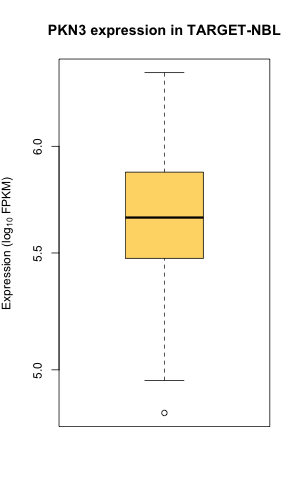

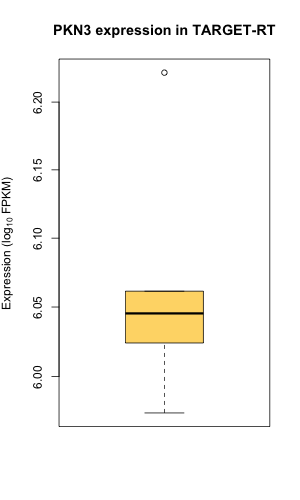

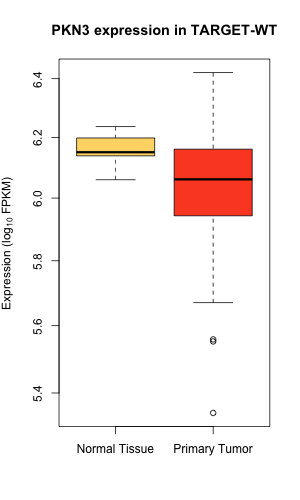

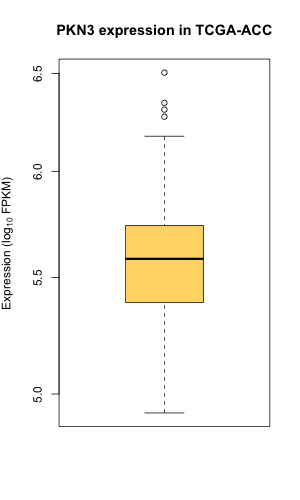

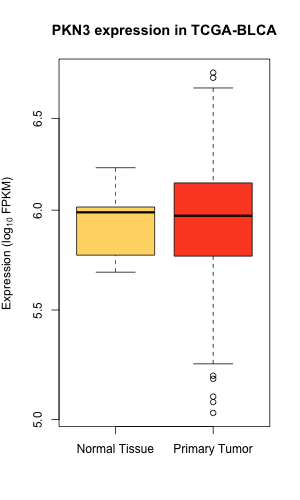

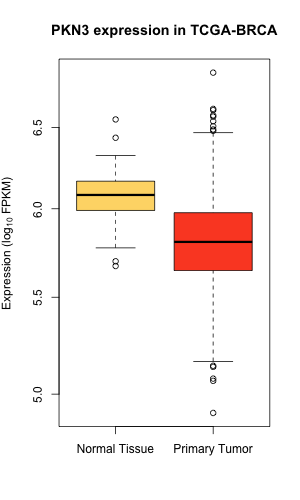

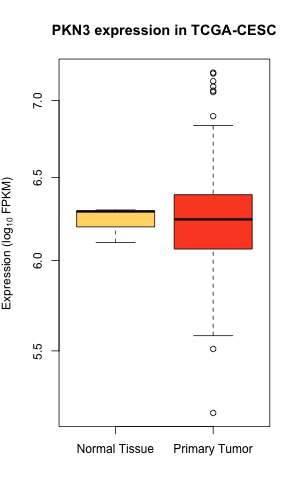

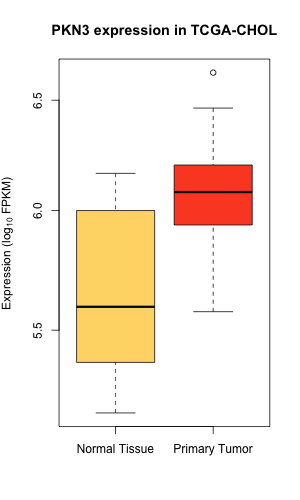

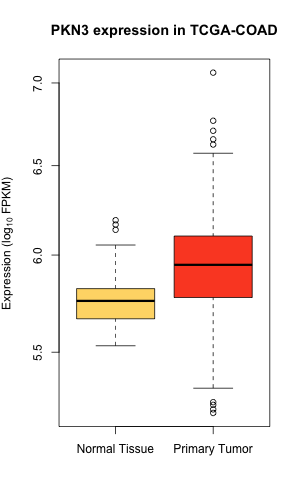

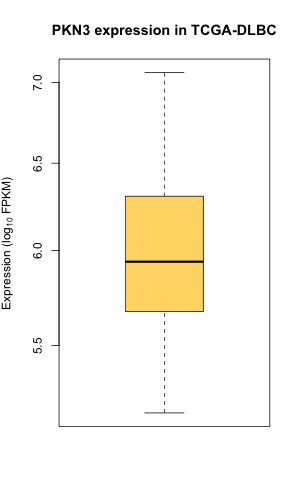

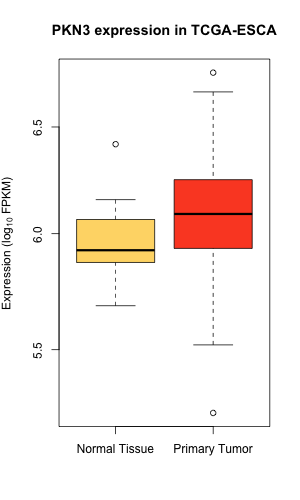

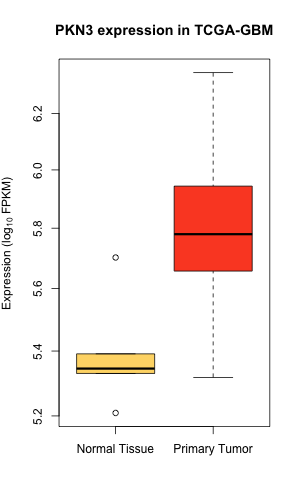

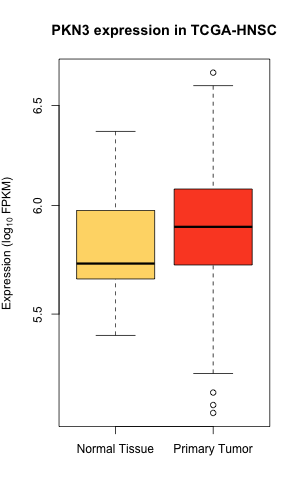

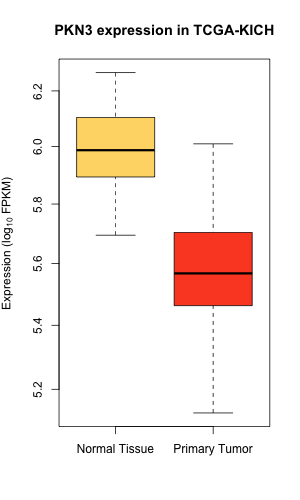

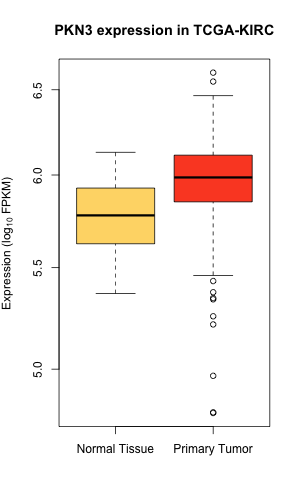

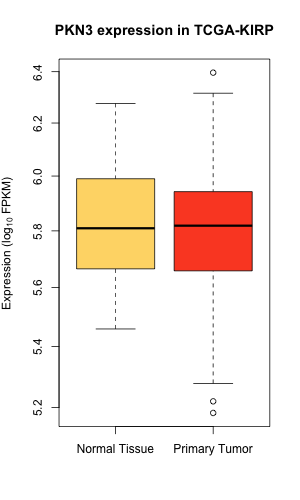


Error in boxplot.default(split(mf[[response]], mf[-response]), ...) : 
  invalid first argument


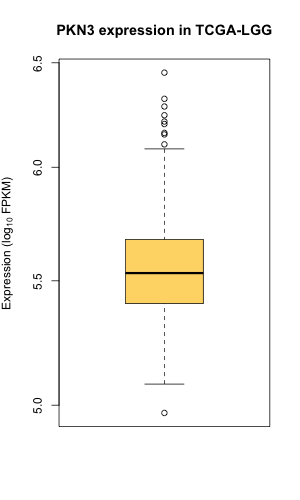

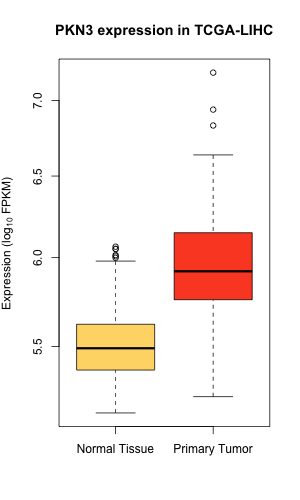

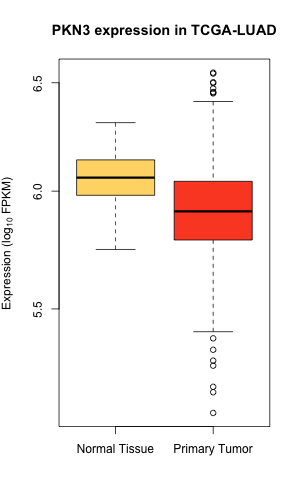

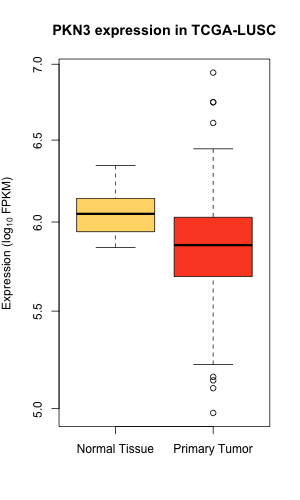

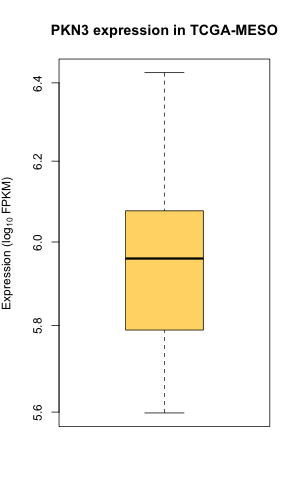

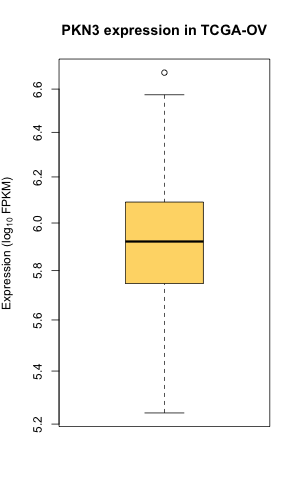

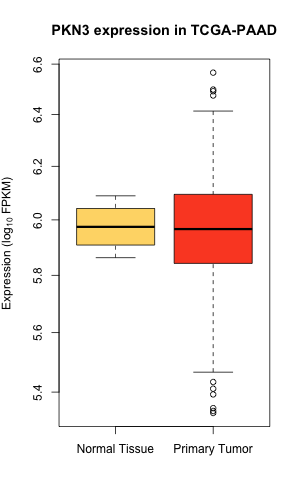

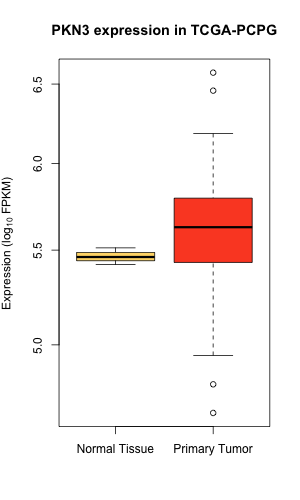

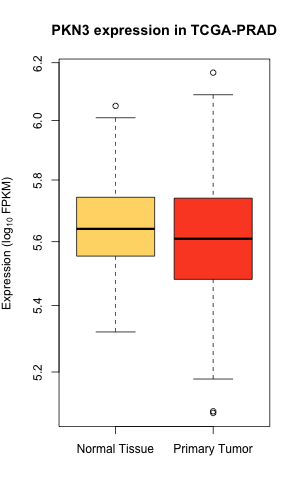

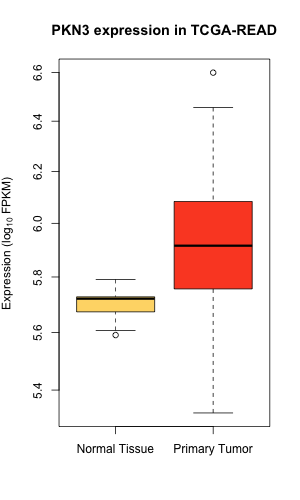

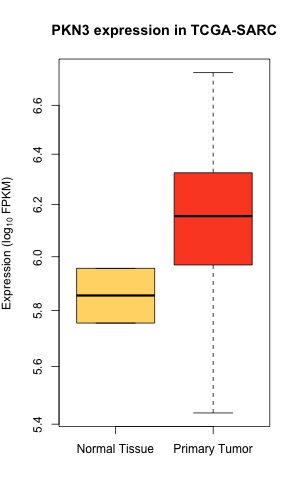

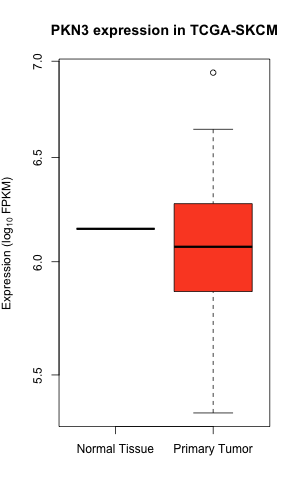

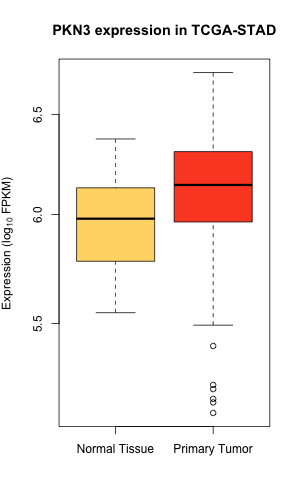

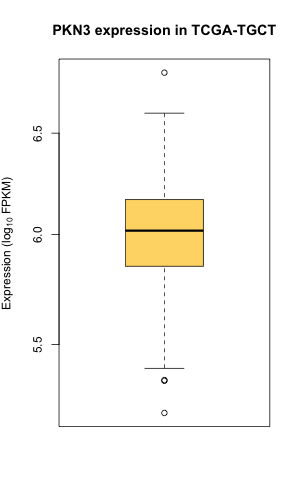

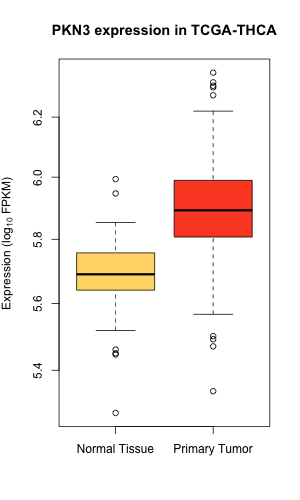

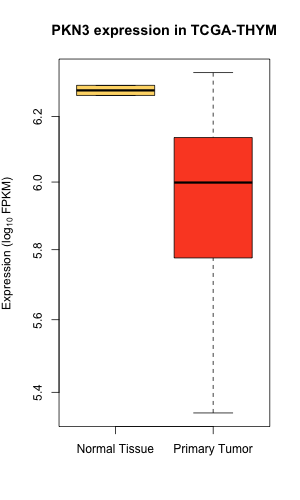

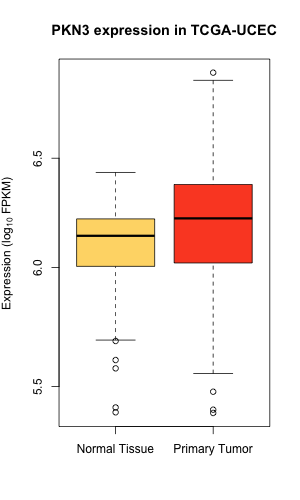

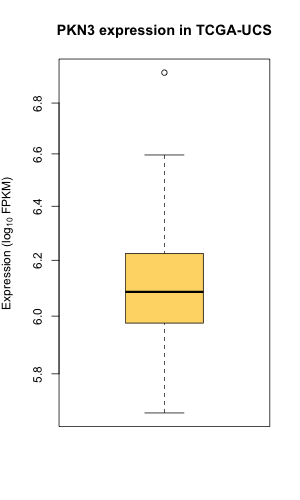

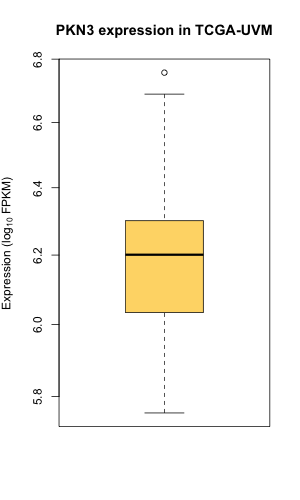

In [159]:
for tumorType in glob.glob('T*'):
    try:
        plotDifferentialExpression('PKN3', tumorType, ['01', '11'])
    except:
        pass

/Users/denis/my-venv/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:

Error in boxplot.default(split(mf[[response]], mf[-response]), ...) : 
  invalid first argument





Error in boxplot.default(split(mf[[response]], mf[-response]), ...) : 
  invalid first argument


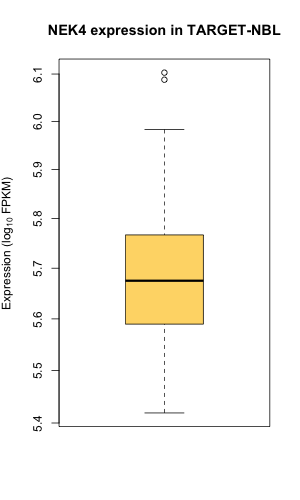

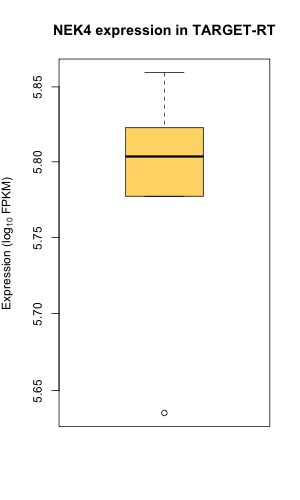

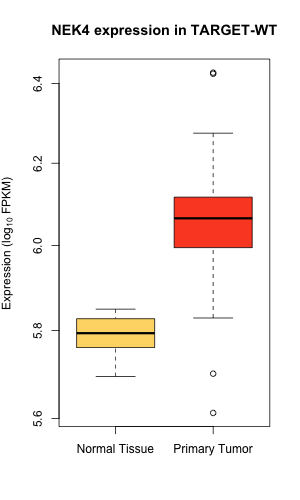

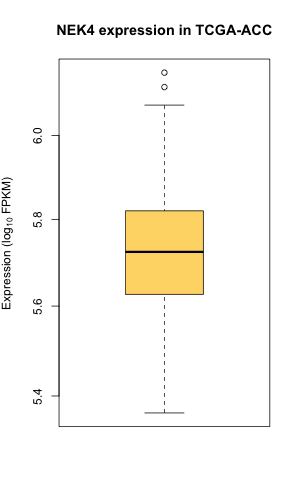

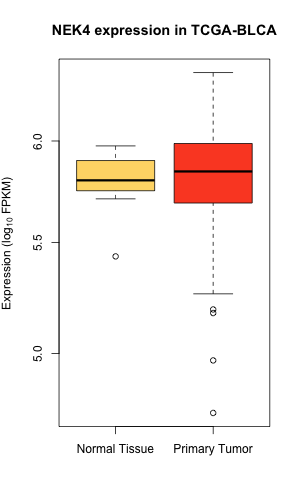

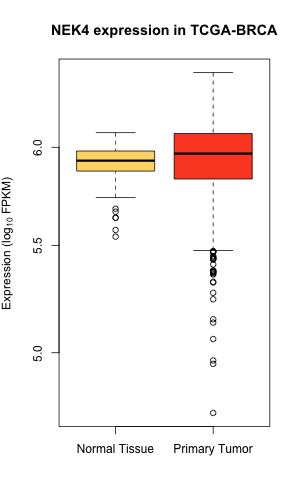

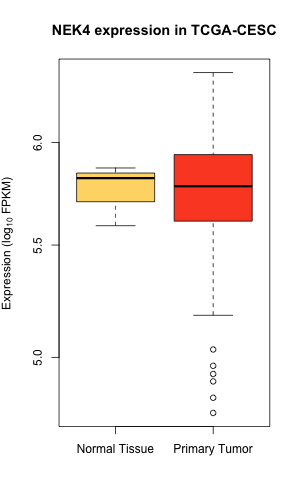

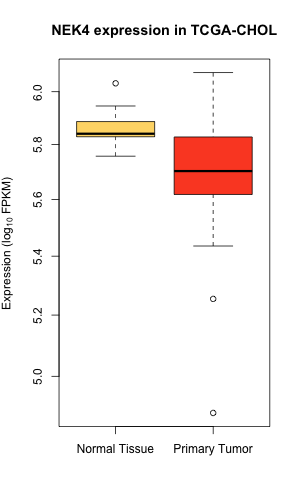

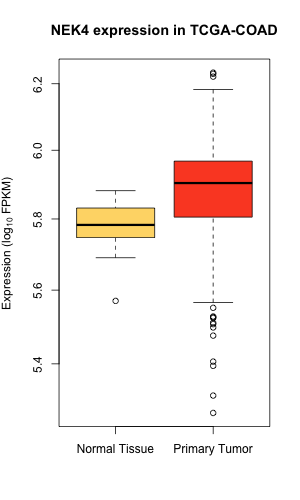

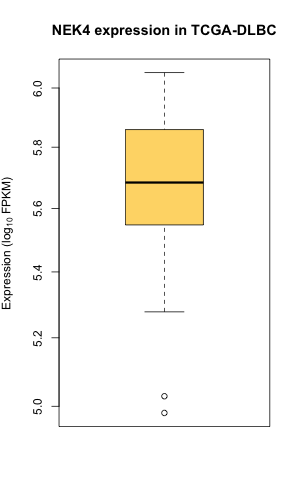

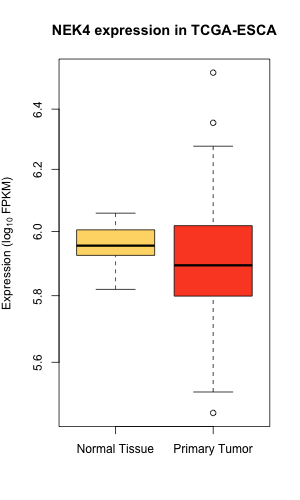

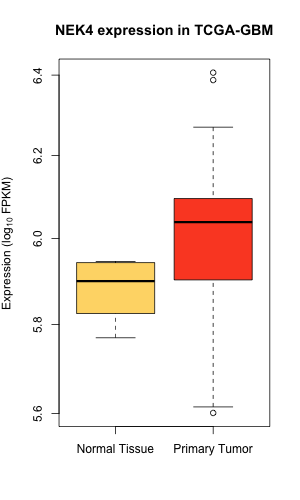

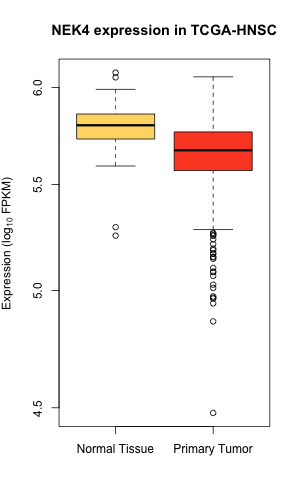

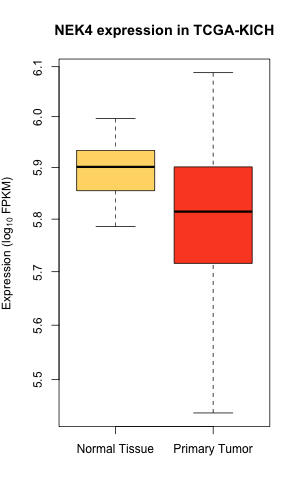

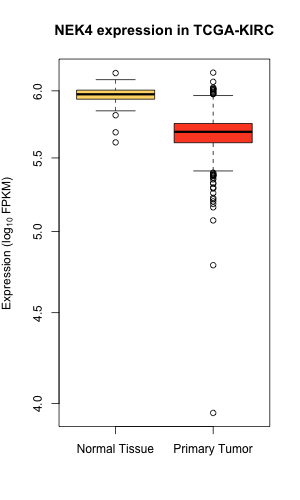

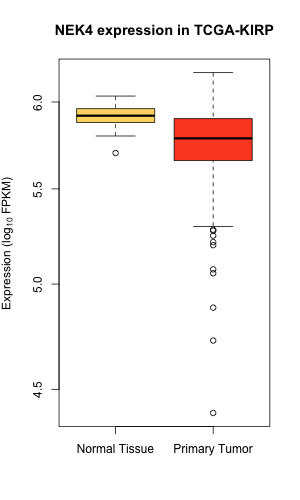


Error in boxplot.default(split(mf[[response]], mf[-response]), ...) : 
  invalid first argument


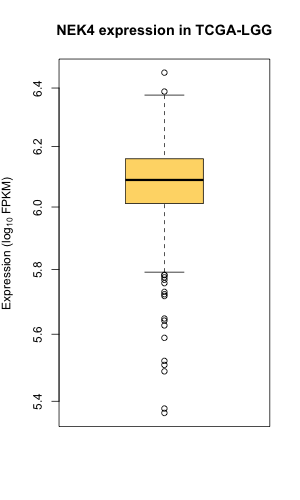

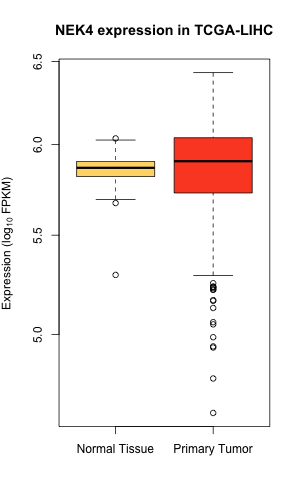

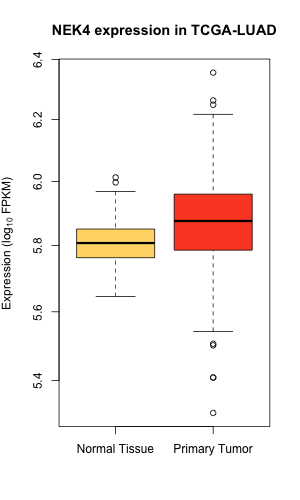

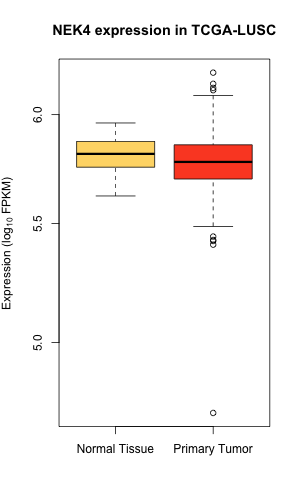

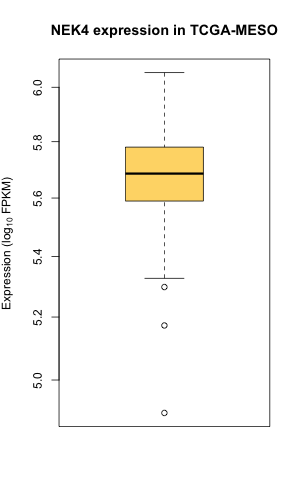

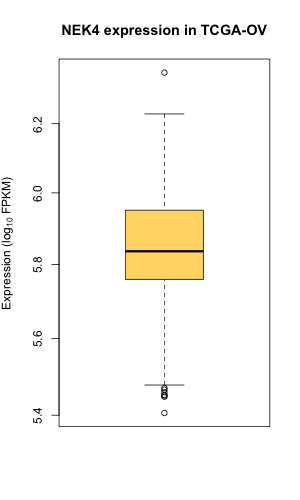

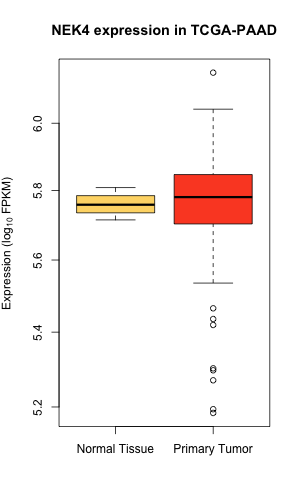

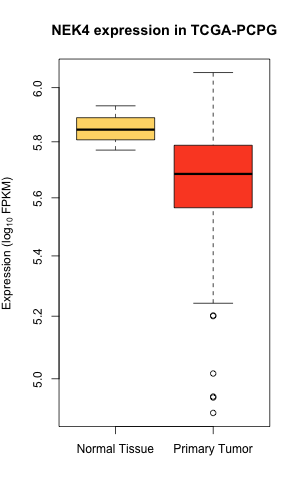

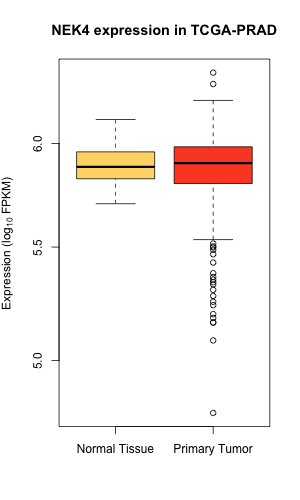

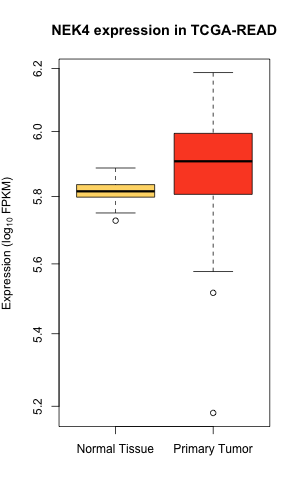

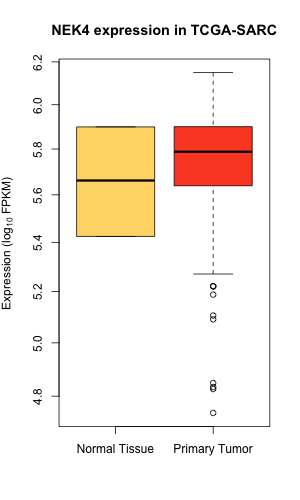

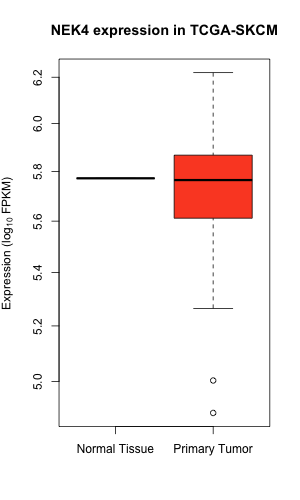

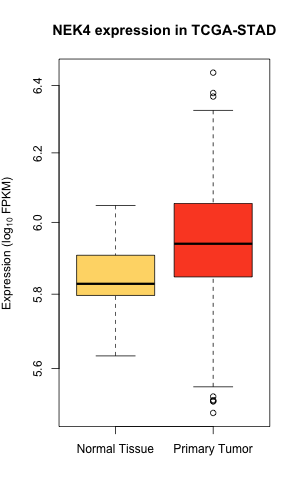

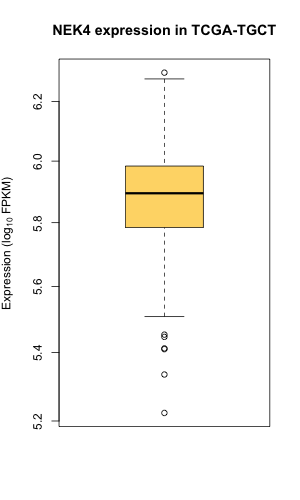

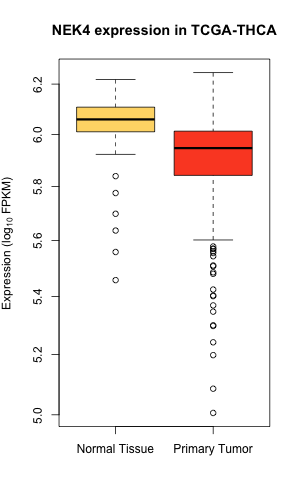

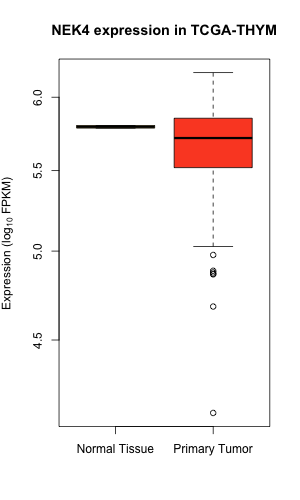

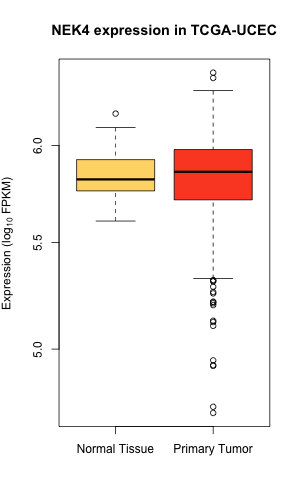

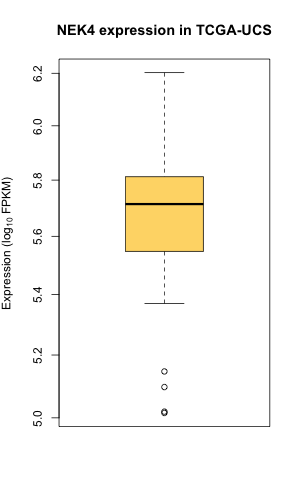

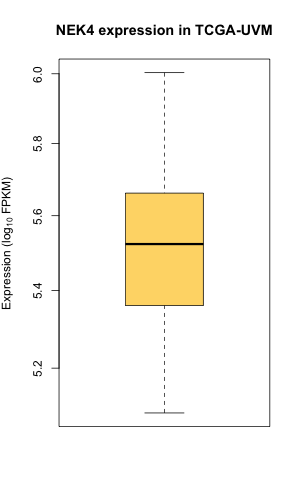

In [157]:
for tumorType in glob.glob('T*'):
    try:
        plotDifferentialExpression('NEK4', tumorType, ['01', '11'])
    except:
        pass

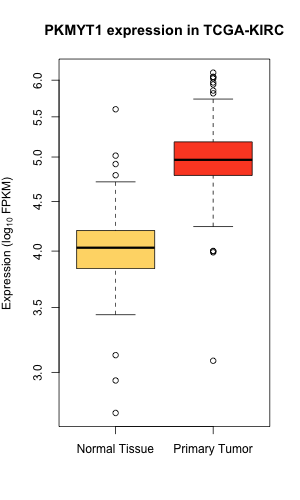

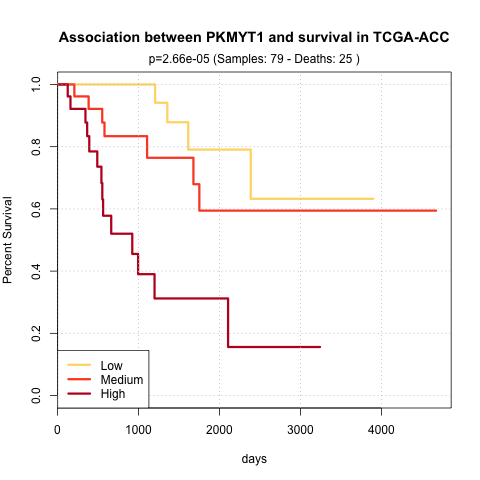

In [112]:
plotSurvivalAssociation('PKMYT1', 'TCGA-ACC', nGroups=3)

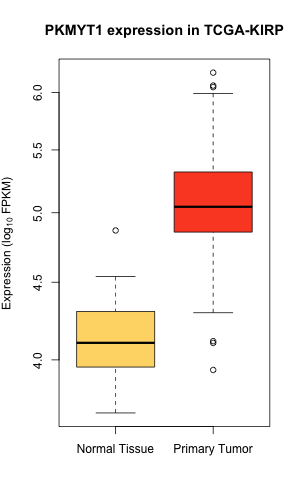

In [151]:
plotDifferentialExpression('PKMYT1', 'TCGA-KIRP', ['01', '11'])

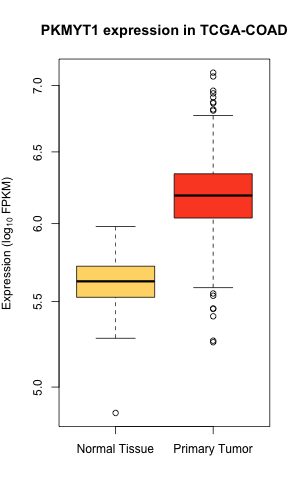

In [153]:
plotDifferentialExpression('PKMYT1', 'TCGA-COAD', ['01', '11'])

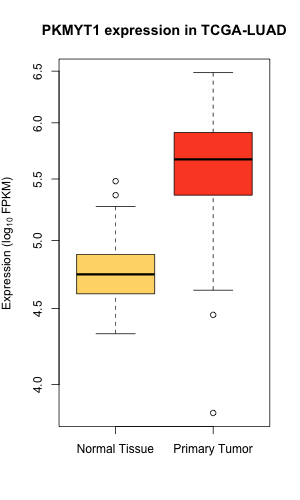

In [154]:
plotDifferentialExpression('PKMYT1', 'TCGA-LUAD', ['01', '11'])

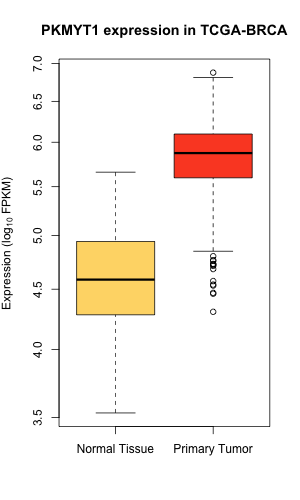

In [148]:
plotDifferentialExpression('PKMYT1', 'TCGA-BRCA', ['01', '11'])

### NEK4

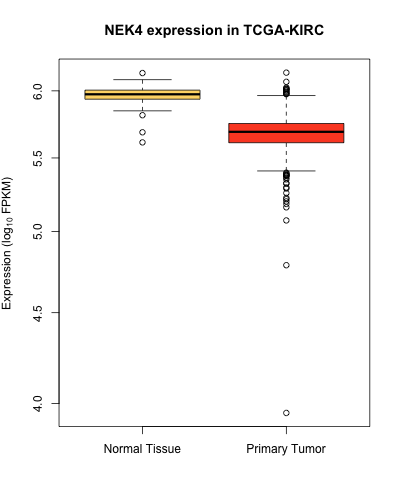

In [133]:
plotDifferentialExpression('NEK4', 'TCGA-KIRC', ['01', '11'])

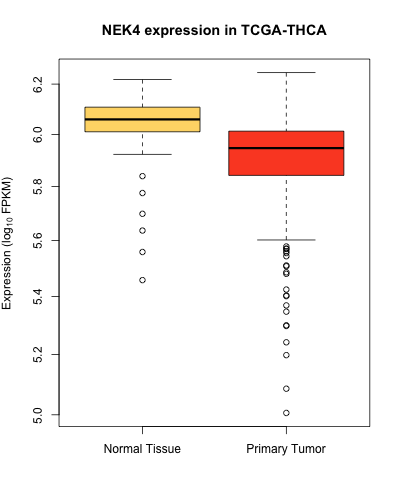

In [136]:
plotDifferentialExpression('NEK4', 'TCGA-THCA', ['01', '11'])

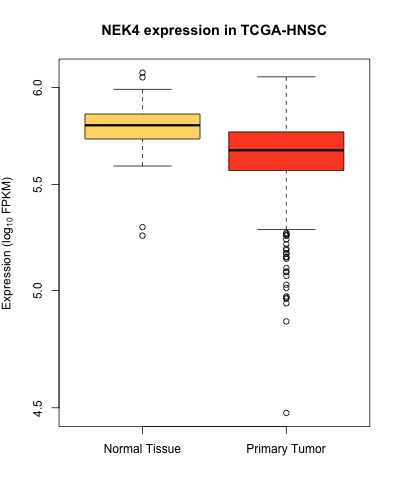

In [137]:
plotDifferentialExpression('NEK4', 'TCGA-HNSC', ['01', '11'])

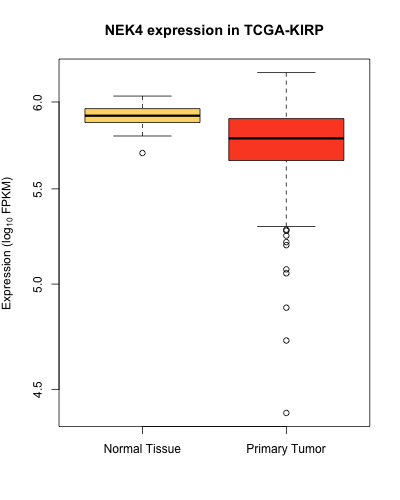

In [139]:
plotDifferentialExpression('NEK4', 'TCGA-KIRP', ['01', '11'])

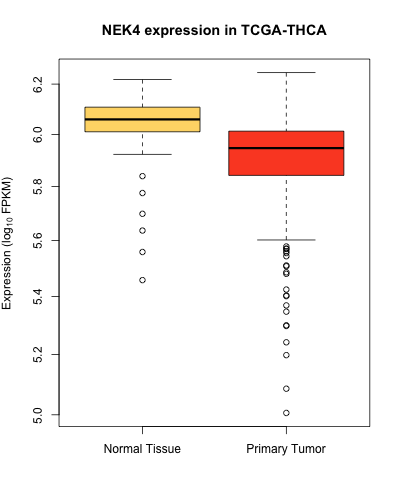

In [141]:
plotDifferentialExpression('NEK4', 'TCGA-THCA', ['01', '11'])